## Using Pipelines with Grid-Search for Cross Validation

Data shape: (100, 100)


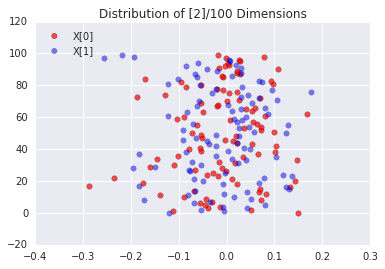

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# create data
from sklearn.datasets import make_regression
X, y = make_regression(random_state=42, effective_rank=90)
print('Data shape: {}'.format(X.shape))

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.scatter(X[0], list(range(0,100)), s=30, c='r', alpha=0.7, label='X[0]')
plt.scatter(X[1], list(range(0,100)), s=30, c='b', alpha=0.5, label='X[1]')
plt.legend(loc='upper left');
plt.title('Distribution of [2]/100 Dimensions')
plt.show()

#### Feature selection and regression without pipelines

In [93]:
# split data
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.5)

# transform data
from sklearn.feature_selection import SelectFpr, f_regression
from sklearn.linear_model import Ridge

fpr = SelectFpr(score_func=f_regression)
fpr.fit(X_train, y_train)
X_train_fpr = fpr.transform(X_train)
X_test_fpr = fpr.transform(X_test)

print('Training size: {} \nFeatures: {} (reduced from {})'
      .format(X_train_fpr.shape[0],X_train_fpr.shape[1], X.shape[1]))

Training size: 50 
Features: 5 (reduced from 100)


In [94]:
# create model
ridge = Ridge()
ridge.fit(X_train_fpr, y_train)
ridge.score(X_test_fpr, y_test)

0.12185693594910552

#### Now, with pipelines:

In [103]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectFpr(score_func=f_regression), Ridge())

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.12185693594910552

The same result as before, in far fewer lines of code.
___

#### Grid-Searching alpha in Ridge

In [107]:
from sklearn.grid_search import GridSearchCV

# without pipeline
param_grid_no_pipeline = {'alpha': 10. ** np.arange(-3, 5)}
pipe.named_steps.keys()

dict_keys(['ridge', 'selectfpr'])

The keys in the dict are the steps in the pipeline

In [108]:
# with pipeline
param_grid = {'ridge__alpha': 10. ** np.arange(-3, 5)}
grid = GridSearchCV(pipe, param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('selectfpr', SelectFpr(alpha=0.05, score_func=<function f_regression at 0x1150f4f28>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

For each split in the data, the training and validation folds are run again.

In [109]:
grid.score(X_test, y_test)

0.53885349326377474

Tuning the parameters has resulted in a considerable increase in permance

In [110]:
grid.best_params_

{'ridge__alpha': 0.10000000000000001}

___
#### Selecting parameters of the preprocessing steps
* Adjusting both the parameters of the feature selection, and the regularisation of the ridge

In [114]:
param_grid = {'ridge__alpha': 10. ** np.arange(-3, 5),
              'selectfpr__alpha': [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]}
grid = GridSearchCV(pipe, param_grid, cv=10)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.99438534427129188

This has resulted in an accurate prediction model

In [115]:
grid.best_params_

{'ridge__alpha': 0.001, 'selectfpr__alpha': 0.3}

Accessing the estimator that Grid-Search CV retrained on the whole training set, with the best parameters, using the best parameter attributes.

In [117]:
final_selectfpr = grid.best_estimator_.named_steps['selectfpr']
final_selectfpr.get_support()

array([False, False, False, False, False, False, False,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False,  True, False,  True, False, False, False, False,  True,
       False,  True, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
        True,  True, False, False, False, False,  True,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False,  True, False], dtype=bool)